In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import collections
import random
import pandas as pd
import datetime
import scipy as sci
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d


In [2]:
# Load the CSV file (You must change this to your own file path)
csv_file_path = 'ff5_filtered_XY_data_19000_to_19120_0.2s_intervals.csv'
data = pd.read_csv(csv_file_path)

# Set agent list (e.g., from A to N)
agents = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N']

# Select only agents that have actual data
valid_agents = [agent for agent in agents if f'X(m)_{agent}' in data.columns and f'Y(m)_{agent}' in data.columns]

# Interpolate the data for the 0th agent (e.g., 'A')
t_data = data['t(s)'].values
t_data = t_data - t_data[0]
X_0 = data[f'X(m)_{valid_agents[0]}'].values
X_0 = X_0 - np.mean(X_0)
Y_0 = data[f'Y(m)_{valid_agents[0]}'].values
Y_0 = Y_0 - np.mean(Y_0)
dX_0 = data[f'dX/dt(m/s)_{valid_agents[0]}'].values
dY_0 = data[f'dY/dt(m/s)_{valid_agents[0]}'].values

# Create interpolation functions
X_0_interp = interp1d(t_data, X_0, kind='cubic', fill_value="extrapolate")
Y_0_interp = interp1d(t_data, Y_0, kind='cubic', fill_value="extrapolate")
dX_0_interp = interp1d(t_data, dX_0, kind='cubic', fill_value="extrapolate")
dY_0_interp = interp1d(t_data, dY_0, kind='cubic', fill_value="extrapolate")

# Compare trajectory (original and interpolated data) for the 0th agent
t_fine = np.linspace(t_data.min(), t_data.max(), 500)  # Finer time range for interpolated data

# Interpolated X, Y data
X_0_interp_values = X_0_interp(t_fine)
Y_0_interp_values = Y_0_interp(t_fine)


In [3]:
### define functions for numerical solution ###
n = len(valid_agents)  # 실제 존재하는 에이전트 수
v0 = 13.0 # averaged speed of all agents in training period

#Distance coeff
lambda1 = 2.924e-01 
lambda2 = 9.978e-02 
lambda3 = -2.072e-02 
lambda4 = -9.346e-02
power1 = 4.944e-01 
power2 = 6.445e-01 
power3 = 1.468e+00
#Velocity coeff
lambda1_v = 2.431e-01 
lambda2_v = 3.095e-01 
lambda3_v = -2.329e-01 
lambda4_v = 6.913e-02
power1_v = -1.861e-01 
power2_v = -1.293e-01 
power3_v = 3.684e-01
ang_threshold = 1.2229e+00


# Interaction function (Agent 0 does not receive force but is included in interaction calculations)
def total_infer_x(s, i, t):
    n_array = np.array(n)
    self_index = np.repeat(i, n - 1)
    
    others_index = list(range(n))
    if i != 0:
        others_index.remove(i)
    
    if i == 0:  # Update the position and velocity of agent 0
        x1 = X_0_interp(t)
        y1 = Y_0_interp(t)
        vi_x = dX_0_interp(t)
        vi_y = dY_0_interp(t)
    else:
        x1 = np.take(s, self_index)
        y1 = np.take(s, self_index + n_array)
        vi_x = np.take(s, 2 * n_array + self_index)  # self
        vi_y = np.take(s, 3 * n_array + self_index)  # self

        x2 = np.take(s, others_index)
        y2 = np.take(s, others_index + n_array)
        vj_x = np.take(s, 2 * n_array + others_index)
        vj_y = np.take(s, 3 * n_array + others_index)

        ### If agent 0 is the sender, use its position and velocity ##
        agent_0_idx = np.where(np.array(others_index) == 0)[0]
        x2[agent_0_idx] = X_0_interp(t)
        y2[agent_0_idx] = Y_0_interp(t)
        vj_x[agent_0_idx] = dX_0_interp(t)
        vj_y[agent_0_idx] = dY_0_interp(t)
        
        v0 = np.sqrt(dX_0_interp(t)**2 + dY_0_interp(t)**2)

        dist = ((x1 - x2) ** 2 + (y1 - y2) ** 2) ** (1 / 2)
        vel_rel = ((vi_x - vj_x) ** 2 + (vi_y - vj_y) ** 2) ** (1 / 2)

        dist_x = (x1 - x2)
        dist_y = (y1 - y2)

        ang_interact = np.arctan2(vi_y * (-dist_x) - vi_x  * (-dist_y), vi_x  * (-dist_x) + vi_y * (-dist_y))
        ang_eff = np.exp(-ang_interact**2 / (2 * ang_threshold**2))

        F_int_x = ((x1 - x2) / dist * (lambda1 * (dist ** power1) \
                                       + lambda2 * (dist ** power2) \
                                       + lambda3 * (dist ** power3) \
                                       + lambda4) + \
                   (vi_x - vj_x) / vel_rel * (lambda1_v * (dist ** power1_v) \
                                             + lambda2_v * (dist ** power2_v) \
                                             + lambda3_v * (dist ** power3_v) \
                                             + lambda4_v)) * ang_eff

        total_interaction_x = sum(F_int_x)

    if i != 0:  # Agent 0 has no self-propulsion force
        v_i_x = s[2 * n + i]
        v_i_y = s[3 * n + i]
        v_i_mag = (v_i_x ** 2 + v_i_y ** 2) ** (1 / 2)
        self_propel_x = 1 * (v_i_x / v_i_mag) * (v0 - v_i_mag)
        return self_propel_x + total_interaction_x
    else:
        return 0  # Agent 0 does not receive any force

def total_infer_y(s, i, t):
    # Calculate interaction force in the y-direction (same logic as in the x-direction)
    n_array = np.array(n)
    self_index = np.repeat(i, n - 1)
    
    others_index = list(range(n))
    if i != 0:
        others_index.remove(i)
    
    if i == 0:
        x1 = X_0_interp(t)
        y1 = Y_0_interp(t)
        vi_x = dX_0_interp(t)
        vi_y = dY_0_interp(t)
    else:
        x1 = np.take(s, self_index)
        y1 = np.take(s, self_index + n_array)
        vi_x = np.take(s, 2 * n_array + self_index)  # self
        vi_y = np.take(s, 3 * n_array + self_index)  # self

        x2 = np.take(s, others_index)
        y2 = np.take(s, others_index + n_array)

        vj_x = np.take(s, 2 * n_array + others_index)
        vj_y = np.take(s, 3 * n_array + others_index)

        ### If agent 0 is the sender, use its position and velocity ##
        agent_0_idx = np.where(np.array(others_index) == 0)[0]
        x2[agent_0_idx] = X_0_interp(t)
        y2[agent_0_idx] = Y_0_interp(t)
        vj_x[agent_0_idx] = dX_0_interp(t)
        vj_y[agent_0_idx] = dY_0_interp(t)
        
        v0 = np.sqrt(dX_0_interp(t)**2 + dY_0_interp(t)**2)

        dist = ((x1 - x2) ** 2 + (y1 - y2) ** 2) ** (1 / 2)
        vel_rel = ((vi_x - vj_x) ** 2 + (vi_y - vj_y) ** 2) ** (1 / 2)

        dist_x = (x1 - x2)
        dist_y = (y1 - y2)

        ang_interact = np.arctan2(vi_y * (-dist_x) - vi_x  * (-dist_y), vi_x  * (-dist_x) + vi_y * (-dist_y))
        ang_eff = np.exp(-ang_interact**2 / (2 * ang_threshold**2))
        
        F_int_y = ((y1 - y2) / dist * (lambda1 * (dist ** power1) \
                                       + lambda2 * (dist ** power2) \
                                       + lambda3 * (dist ** power3) \
                                       + lambda4) + \
                   (vi_y - vj_y) / vel_rel * (lambda1_v * (dist ** power1_v) \
                                              + lambda2_v * (dist ** power2_v) \
                                              + lambda3_v * (dist ** power3_v) \
                                              + lambda4_v)) * ang_eff

        total_interaction_y = sum(F_int_y)

    if i != 0:
        v_i_x = s[2 * n + i]
        v_i_y = s[3 * n + i]
        v_i_mag = (v_i_x ** 2 + v_i_y ** 2) ** (1 / 2)
        self_propel_y = 1 * (v_i_y / v_i_mag) * (v0 - v_i_mag)
        return self_propel_y + total_interaction_y
    else:
        return 0  # Agent 0 does not receive any force


def F_infer_ivp(t, s):
    return np.concatenate((s[2 * n:3 * n], s[3 * n:4 * n], \
                           [total_infer_x(s, i, t) for i in range(n)] + np.random.normal(0, 10, size=n), \
                           [total_infer_y(s, i, t) for i in range(n)] + np.random.normal(0, 10, size=n)))


In [4]:
########## Initial condition ##########

# Load initial positions and velocities of the remaining agents from the CSV file
position_list_x = []
position_list_y = []
velocity_list_x = []
velocity_list_y = []

for agent in valid_agents[0:]:  # Exclude agent 0 and set initial values for the remaining agents
    X_agents = data[f'X(m)_{agent}'].values - np.mean(data[f'X(m)_{agent}'].values)
    Y_agents = data[f'Y(m)_{agent}'].values - np.mean(data[f'Y(m)_{agent}'].values)
    dX_agents = data[f'dX/dt(m/s)_{agent}'].values - np.mean(data[f'dX/dt(m/s)_{agent}'].values)
    dY_agents = data[f'dY/dt(m/s)_{agent}'].values - np.mean(data[f'dY/dt(m/s)_{agent}'].values)
    
    position_list_x.append(X_agents[0])  # The first value is the initial position
    position_list_y.append(Y_agents[0])  # The first value is the initial position
    velocity_list_x.append(dX_agents[0])  # The first value is the initial velocity
    velocity_list_y.append(dY_agents[0])  # The first value is the initial velocity

nodes_np = np.array([position_list_x, position_list_y, velocity_list_x, velocity_list_y], dtype=np.float32)

s0 = nodes_np.reshape(-1)


In [5]:
dt=0.1
T=100
t=np.arange(0,T+dt,dt)

solution=solve_ivp(F_infer_ivp,[0,T],s0, method='RK45', max_step= 0.01, t_eval=t)

print(solution)

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 384266
     njev: 0
      nlu: 0
      sol: None
   status: 0
  success: True
        t: array([  0. ,   0.1,   0.2, ...,  99.8,  99.9, 100. ])
 t_events: None
        y: array([[ 5.22351532e+01,  5.31733769e+01,  5.41151104e+01, ...,
         5.77835152e+02,  5.78147820e+02,  5.78452738e+02],
       [ 1.99700031e+01,  2.11473563e+01,  2.23452673e+01, ...,
         9.37309509e+01,  9.29874753e+01,  9.22290990e+01],
       [ 4.25242758e+00,  5.48317609e+00,  6.74265722e+00, ...,
         8.61525928e+01,  8.53595422e+01,  8.45451565e+01],
       ...,
       [-3.72076035e-01,  1.56725324e-01,  7.44296905e-01, ...,
         1.80027723e+01,  1.80735122e+01,  1.77735013e+01],
       [-6.26547277e-01, -2.49671715e-01,  1.55810492e-01, ...,
         1.43728338e+01,  1.45004664e+01,  1.46011989e+01],
       [ 5.26631260e+00,  5.31893080e+00,  5.30194235e+00, ...,
         1.34603800e+01,  1.37565197e+01

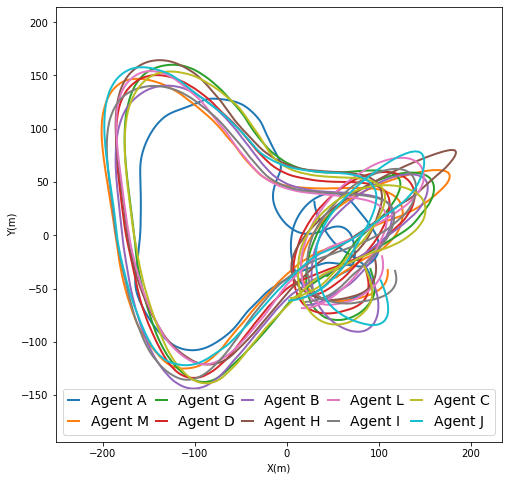

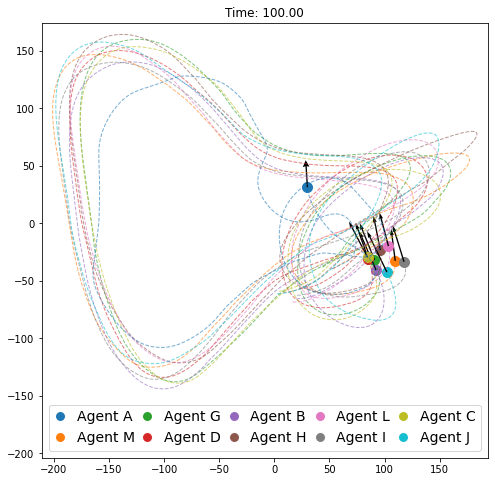

In [6]:
import matplotlib.animation as animation
import numpy as np
import matplotlib.pyplot as plt

# Solution from solve_ivp for the rest of the agents
solution_plot = np.transpose(solution.y)
dt_plot = 0.2
# Time steps for plotting - set at 1-second intervals (select indices at 1-second intervals)
indices = np.arange(0, len(solution_plot), int(dt_plot/dt))  # Select indices at 1-second intervals
t_plot = np.arange(0, T + dt_plot, dt_plot)  # Time at 1-second intervals

# The positions and velocities of the remaining agents are selected from solve_ivp results at 1-second intervals
h = solution_plot[indices, 0:2 * n]
velocity = solution_plot[indices, 2 * n:4 * n]

# Calculate the overall range
x_min = min(np.min(h[:, 1:n]), np.min(X_0))
x_max = max(np.max(h[:, 1:n]), np.max(X_0))
y_min = min(np.min(h[:, n+1:]), np.min(Y_0))
y_max = max(np.max(h[:, n+1:]), np.max(Y_0))

# Set the valid_agents list and match them to the desired_order
valid_agents = [agent for agent in agents if f'X(m)_{agent}' in data.columns and f'Y(m)_{agent}' in data.columns]
desired_order = ['A', 'M', 'G', 'D', 'B', 'H', 'L', 'I', 'C', 'J']  # Desired order
agent_indices = [valid_agents.index(agent) for agent in desired_order if agent in valid_agents]

# --- Static trajectory plot ---
fig_traj, ax_traj = plt.subplots(figsize=(8, 8))

# Plot trajectories for each agent in the order of agent_indices
for j, agent_idx in enumerate(agent_indices):
    if agent_idx == 0:
        ax_traj.plot(X_0_interp(t_plot), Y_0_interp(t_plot), label=f'Agent {desired_order[j]}', lw=2, color=plt.cm.tab10(j))
    else:
        ax_traj.plot(h[:, agent_idx], h[:, n + agent_idx], label=f'Agent {desired_order[j]}', lw=2, color=plt.cm.tab10(j))

ax_traj.set_xlim(x_min - 50, x_max + 50)
ax_traj.set_ylim(y_min - 50, y_max + 50)
ax_traj.set_xlabel('X(m)')
ax_traj.set_ylabel('Y(m)')
ax_traj.legend(loc='lower center', fontsize=14, handlelength=0.8, columnspacing=0.5, ncol=n // 2)
plt.show()

# Plot settings for animation
fig = plt.figure(figsize=(8, 8))
ax = plt.axes()

# Animation function
def animate(i):
    ax.clear()
    
    # Data for agent 0 (taken from the CSV at 1-second intervals)
    x_0 = X_0_interp(t_plot[i])
    y_0 = Y_0_interp(t_plot[i])
    vx_0 = dX_0_interp(t_plot[i])
    vy_0 = dY_0_interp(t_plot[i])
    
    # Data for the remaining agents (from solve_ivp results, at 1-second intervals, according to desired_order)
    for j, agent_idx in enumerate(agent_indices[1:], start=1):
        # Display current position
        ax.scatter(h[i, agent_idx], h[i, n + agent_idx], color=plt.cm.tab10(j), s=100)

        # Display velocity vectors
        ax.quiver(h[i, agent_idx], h[i, n + agent_idx], velocity[i, agent_idx], velocity[i, n + agent_idx],
                  scale_units='xy', angles='xy', scale=0.5, width=0.003, color='k')
        
        # Draw past trajectory as dashed lines
        ax.plot(h[:i + 1, agent_idx], h[:i + 1, n + agent_idx], linestyle='--', color=plt.cm.tab10(j), lw=1, alpha=0.6)

    # Display position and trajectory for agent 0
    ax.scatter(x_0, y_0, color=plt.cm.tab10(0), s=100, label="Agent 0 (from CSV)")
    ax.quiver(x_0, y_0, vx_0, vy_0, scale_units='xy', angles='xy', scale=0.5, width=0.003, headwidth=5, color='k')
    ax.plot(X_0_interp(t_plot[:i + 1]), Y_0_interp(t_plot[:i + 1]), linestyle='--', color=plt.cm.tab10(0), lw=1, alpha=0.6)

    # Set the legend (according to desired_order)
    handles = [plt.Line2D([0], [0], marker='o', color='w', label=f'Agent {desired_order[j]}',
                          markerfacecolor=plt.cm.tab10(j), markersize=10) for j in range(len(agent_indices))]

    # Plot title and limits
    ax.set_title(f'Time: {t_plot[i]:.2f}')
    ax.set_xlim(x_min - 10, x_max + 10)
    ax.set_ylim(y_min - 60, y_max + 10)
    ax.legend(handles=handles, loc='lower center', fontsize=14, handlelength=0.8, columnspacing=0.5, ncol=n // 2)

# Create animation
anim = animation.FuncAnimation(fig, animate, frames=len(t_plot))

# Display animation
from IPython.display import HTML
HTML(anim.to_html5_video())
